In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
%matplotlib inline

In [2]:
train = pd.read_csv('train.csv')

In [4]:
test = pd.read_csv("test.csv")

In [3]:
train.head(4)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000


In [5]:
test.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [8]:
data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'], test.loc[:,'MSSubClass':'SaleCondition']))

## Data Processing ##

Transform skewed numeric feature by taking log(feature + 1)
Create dummy variable for categorical variable
Replacing NAN value by means of respective columns

In [11]:
# log transform target variable
train["SalePrice"] = np.log1p(train['SalePrice'])

# Log transform the skewed numeric feature
numeric_feat = data.dtypes[data.dtypes != 'object'].index
skewed_feat = train[numeric_feat].apply(lambda x: skew(x.dropna()))
skewed_feat = skewed_feat[skewed_feat > 0.75]
skewed_feat = skewed_feat.index

data[skewed_feat] = np.log1p(data[skewed_feat])

In [12]:
data = pd.get_dummies(data)

In [13]:
data = data.fillna(data.mean())

In [14]:
X_train = data[:train.shape[0]]
X_test = data[train.shape[0]:]
y = train.SalePrice

## Models ##
Now i am going to use Regularized linear model from sklearn. I will use both Lasso and Rigid model.
And we will choose best tuning parameter.


In [18]:
from sklearn.linear_model import Ridge, RidgeCV, LassoCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y, scoring= "neg_mean_squared_error", cv = 5))
    return(rmse)

In [19]:
model_ridge = Ridge()

The main tuning parameter of Ridge model is alpha - which measures how flexible our model is.Higher the Regularization less proned our model , gives tendency to overfit our model.

In [30]:
alphas1 = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas1]

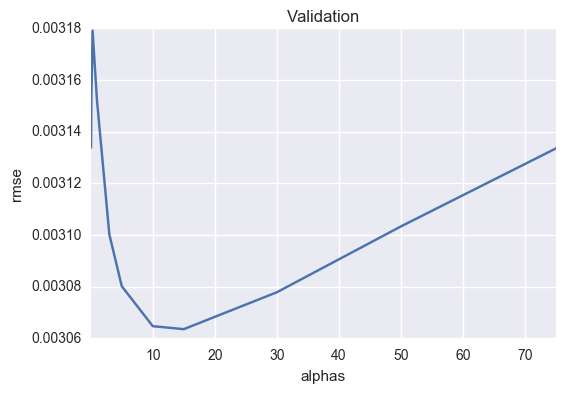

In [31]:
cv_ridge = pd.Series(cv_ridge, index = alphas1)
cv_ridge.plot(title = "Validation")
plt.xlabel("alphas")
plt.ylabel("rmse")

Here we can see U-shaped , when alpha value is too small, regularization is too strong and model can not capture all complexity of data. And when alpha is large value model starts overfitting. When value is 10,model is in middle neither more regularized and nor overfit.

In [25]:
cv_ridge.min()

0.0030635512240207597

Now we will use Lasso Model

In [23]:
model_lasso = LassoCV(alphas= [1, 0.1, 0.001, 0.0005]).fit(X_train, y)

In [27]:
rmse_cv(model_lasso).min()

0.0036274494890560292

Here cv_ridge model is doing better job so we will use it for prediction.

In [33]:
model_ridge = Ridge(alpha = 10)

In [34]:
model_ridge.fit(X_train, y)

Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [36]:
pred = model_ridge.predict(X_test)

In [38]:
pred

array([ 1.264802  ,  1.26841094,  1.27108215, ...,  1.27067538,
        1.26260635,  1.2791606 ])